In [1]:
# ECG Classification with CNN using Spectrograms
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from scipy import signal
from scipy.signal import spectrogram
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.13.0


**dataset link:** https://www.kaggle.com/datasets/shayanfazeli/heartbeat

This dataset is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The number of samples in both collections is large enough for training a deep neural network.

In [5]:
# Load the dataset from Kaggle
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)

print("Training dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("\nFirst few rows of training data:")
print(train_df.head())
print("\nMissing values in train:", train_df.isnull().sum().sum())
print("Missing values in test:", test_df.isnull().sum().sum())

# Combine for analysis (last column is the label)
# For MIT-BIH heartbeat dataset, last column is typically the class label
# and the rest are ECG signal features
print(f"\nNumber of features: {train_df.shape[1] - 1}")
print(f"Number of classes in train: {train_df.iloc[:, -1].nunique()}")
print(f"Number of classes in test: {test_df.iloc[:, -1].nunique()}")


Training dataset shape: (87554, 188)
Test dataset shape: (21892, 188)

First few rows of training data:
        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.

DATA ANALYSIS

Class distribution in training set:
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
Name: 187, dtype: int64

Class distribution in test set:
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
Name: 187, dtype: int64

Overall class distribution:
0.0    90589
1.0     2779
2.0     7236
3.0      803
4.0     8039
Name: 187, dtype: int64

Total samples: 109446
Number of classes: 5


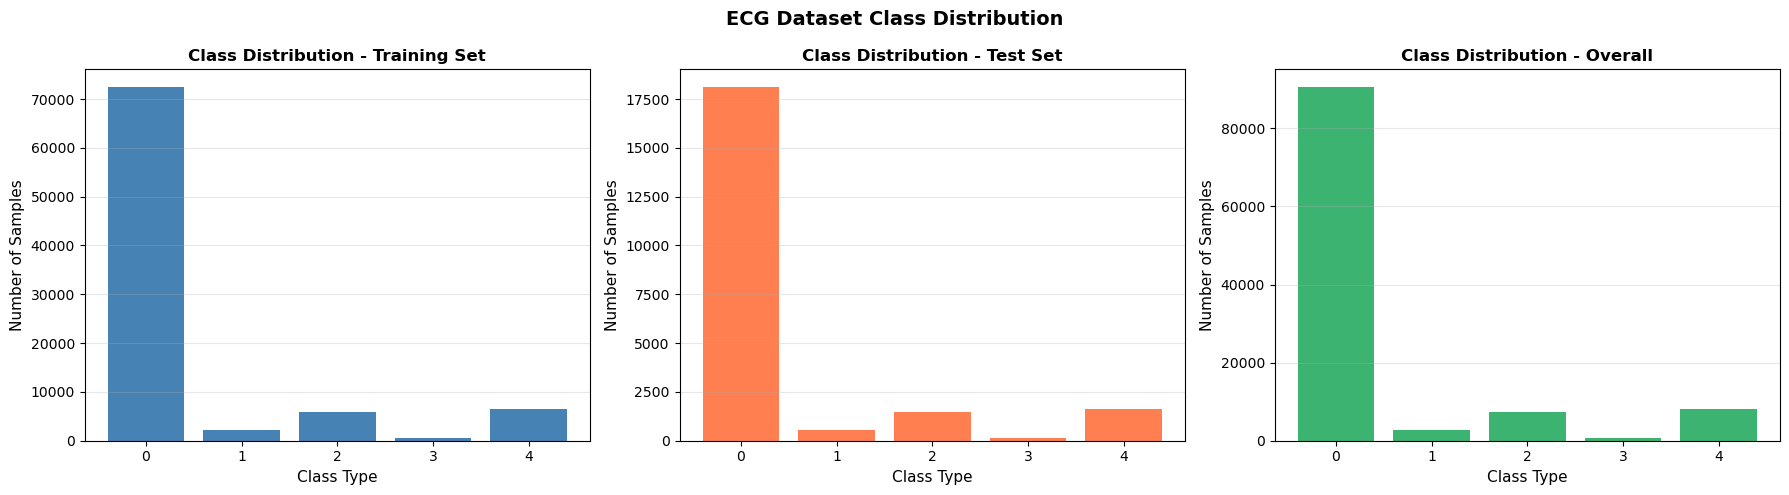


Class percentages (Overall):
Class 0: 90589 (82.77%)
Class 1: 2779 (2.54%)
Class 2: 7236 (6.61%)
Class 3: 803 (0.73%)
Class 4: 8039 (7.35%)


In [6]:
# Data Analysis
print("=" * 50)
print("DATA ANALYSIS")
print("=" * 50)

# Extract labels (last column)
train_labels = train_df.iloc[:, -1]
test_labels = test_df.iloc[:, -1]

# Combine for overall analysis
all_labels = pd.concat([train_labels, test_labels])

# Check class distribution
print("\nClass distribution in training set:")
train_class_counts = train_labels.value_counts().sort_index()
print(train_class_counts)

print("\nClass distribution in test set:")
test_class_counts = test_labels.value_counts().sort_index()
print(test_class_counts)

print("\nOverall class distribution:")
all_class_counts = all_labels.value_counts().sort_index()
print(all_class_counts)
print(f"\nTotal samples: {len(all_labels)}")
print(f"Number of classes: {len(all_class_counts)}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set
axes[0].bar(train_class_counts.index, train_class_counts.values, color='steelblue')
axes[0].set_title('Class Distribution - Training Set', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class Type', fontsize=11)
axes[0].set_ylabel('Number of Samples', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Test set
axes[1].bar(test_class_counts.index, test_class_counts.values, color='coral')
axes[1].set_title('Class Distribution - Test Set', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class Type', fontsize=11)
axes[1].set_ylabel('Number of Samples', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Overall
axes[2].bar(all_class_counts.index, all_class_counts.values, color='mediumseagreen')
axes[2].set_title('Class Distribution - Overall', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Class Type', fontsize=11)
axes[2].set_ylabel('Number of Samples', fontsize=11)
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('ECG Dataset Class Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate class percentages
print("\nClass percentages (Overall):")
for class_type, count in all_class_counts.items():
    percentage = (count / len(all_labels)) * 100
    print(f"Class {int(class_type)}: {count} ({percentage:.2f}%)")


In [7]:
# Separate features and target
# Last column is the label, rest are features
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

print(f"Training feature shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test feature shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nSample feature values (first 5 features of first sample):")
print(X_train[0, :5])


Training feature shape: (87554, 187)
Training target shape: (87554,)
Test feature shape: (21892, 187)
Test target shape: (21892,)
Number of features: 187

Sample feature values (first 5 features of first sample):
[0.97794116 0.92647058 0.68137252 0.24509804 0.15441176]


In [8]:
# Data Processing: Handle imbalanced dataset with SMOTE
print("=" * 50)
print("DATA PROCESSING")
print("=" * 50)

# Labels are already encoded (0, 1, 2, 3, 4)
# Get unique classes for naming
unique_classes = np.unique(np.concatenate([y_train, y_test]))
class_names = [f"Class_{int(cls)}" for cls in unique_classes]

print(f"\nOriginal class distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures standardized.")
print(f"Training shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

# Apply SMOTE to training set only
print("\nApplying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Train set: {X_train_balanced.shape[0]} samples")
print(f"\nBalanced class distribution in training set:")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {int(cls)}: {count}")


DATA PROCESSING

Original class distribution in training set:
Class 0: 72471
Class 1: 2223
Class 2: 5788
Class 3: 641
Class 4: 6431

Features standardized.
Training shape: (87554, 187)
Test shape: (21892, 187)

Applying SMOTE to balance training data...
After SMOTE - Train set: 362355 samples

Balanced class distribution in training set:
Class 0: 72471
Class 1: 72471
Class 2: 72471
Class 3: 72471
Class 4: 72471


VISUALIZING CLASS DIFFERENCES


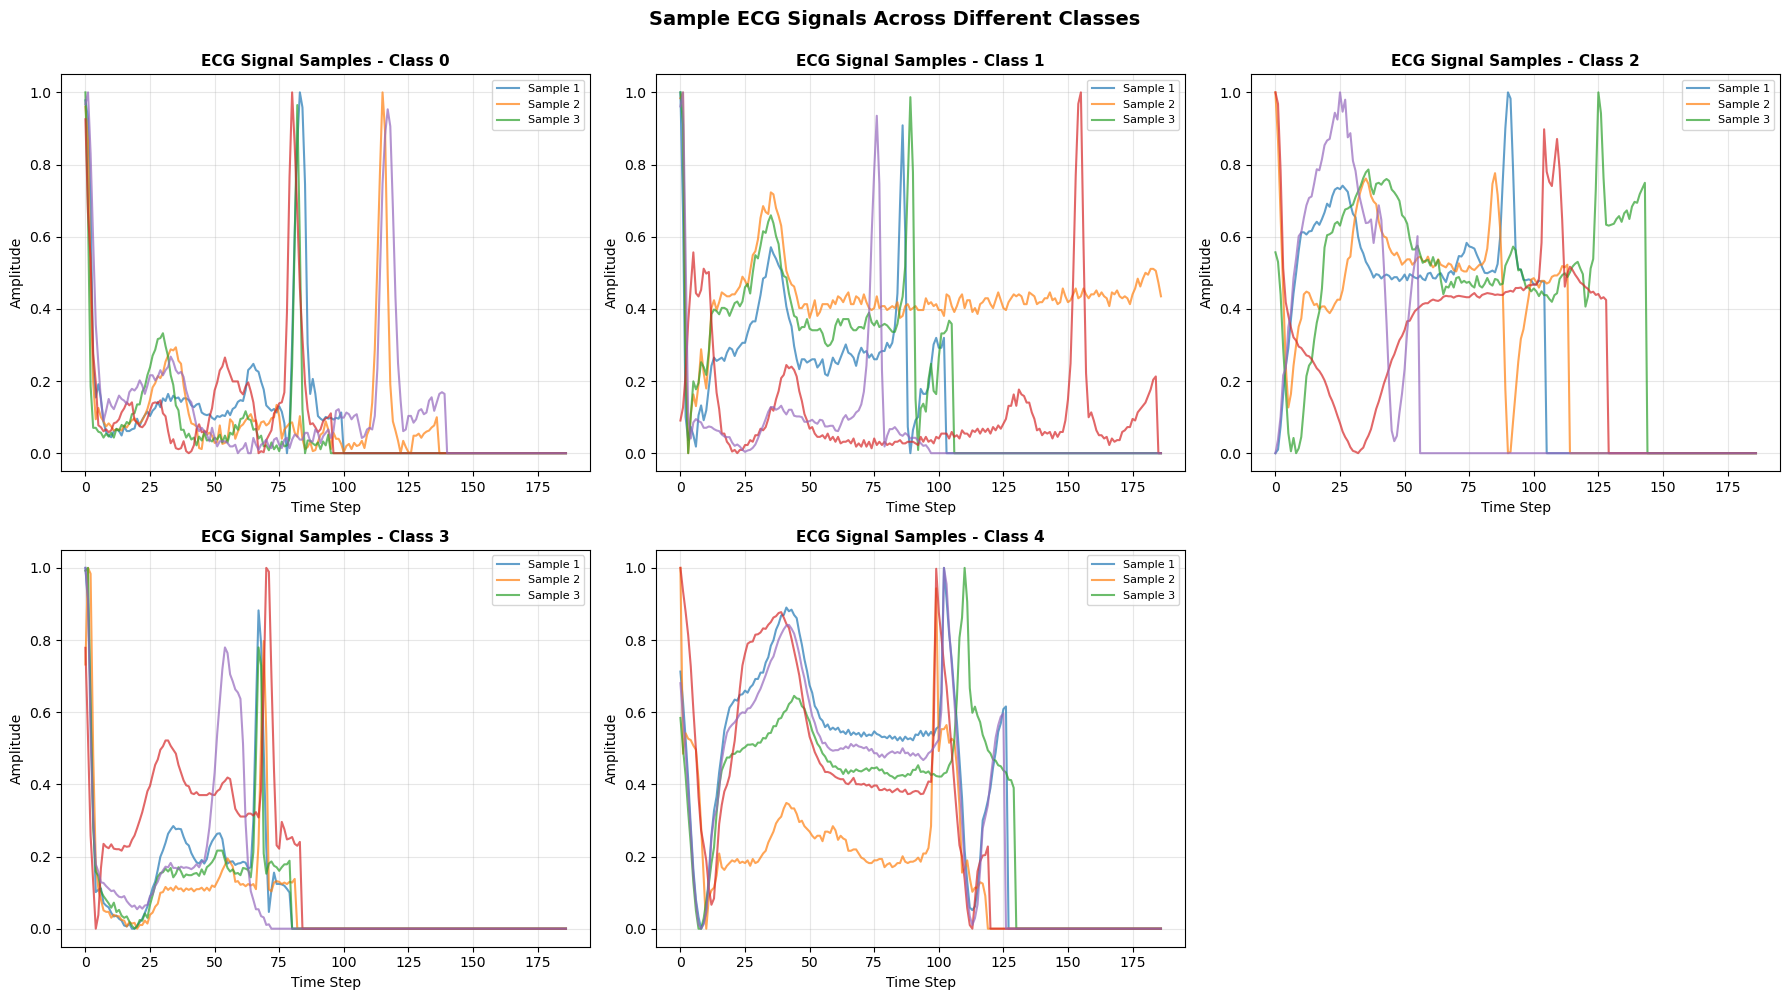


Generating Spectrograms...


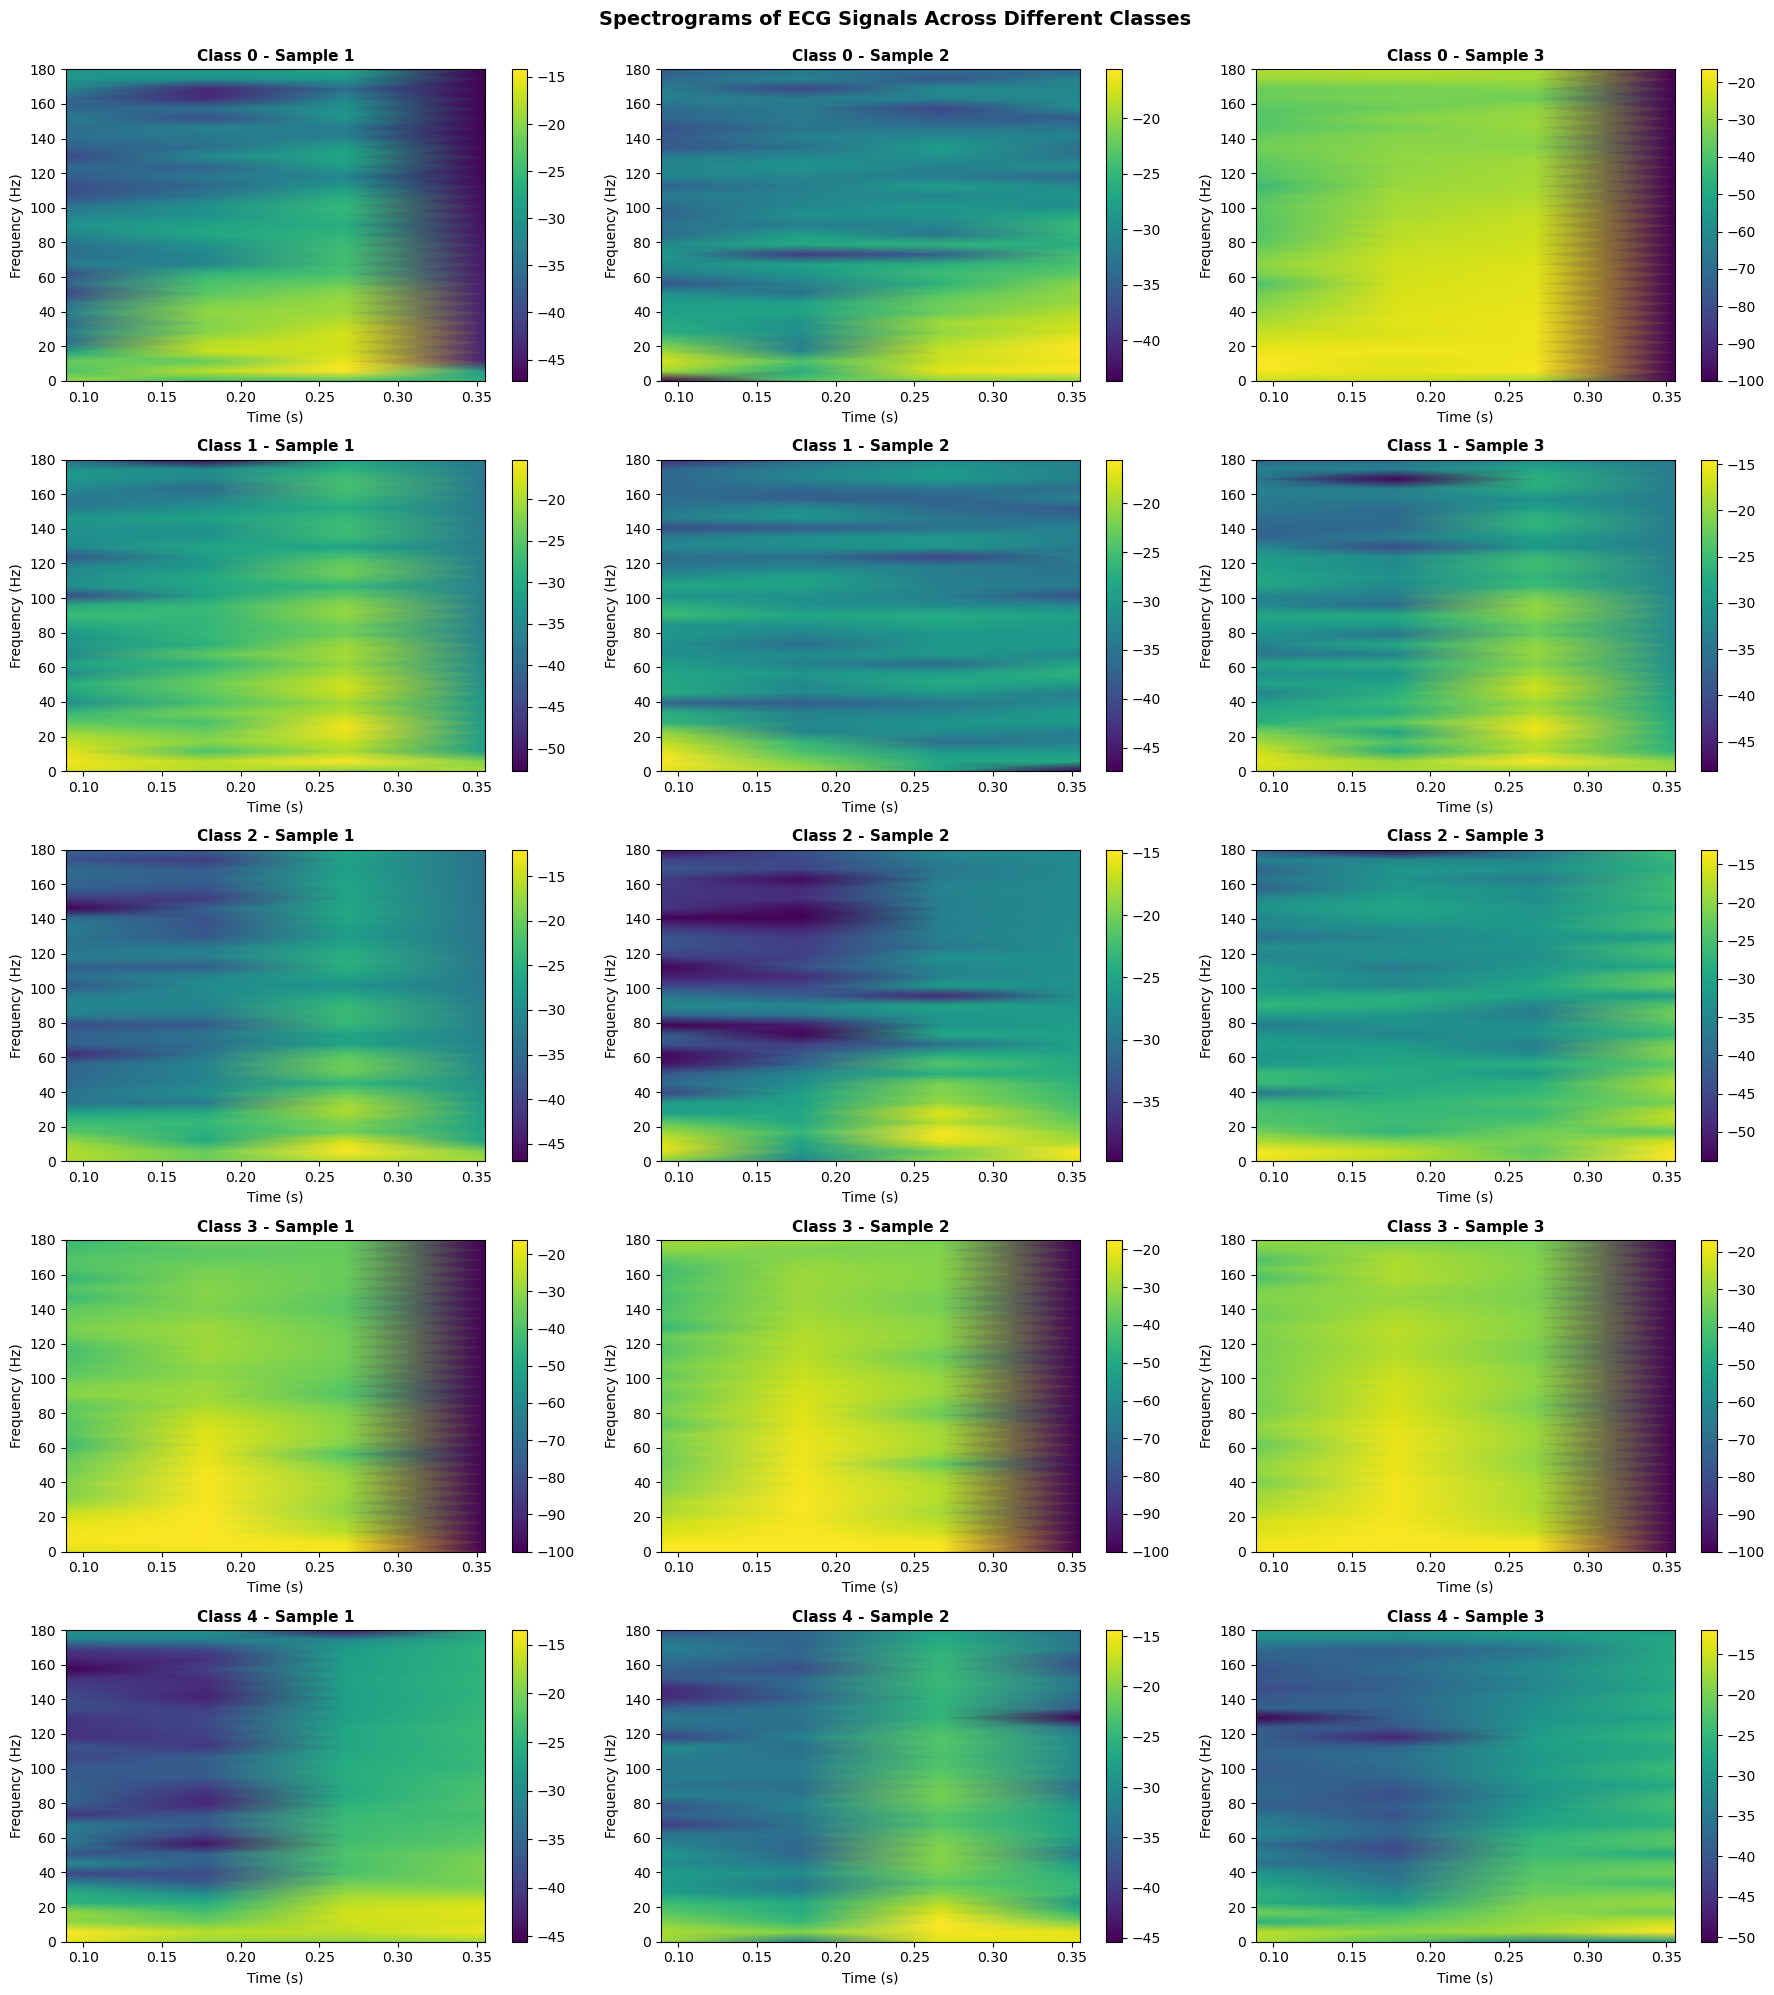

In [10]:
# Plot data for different classes to understand differences
print("=" * 50)
print("VISUALIZING CLASS DIFFERENCES")
print("=" * 50)

# Visualize sample ECG signals for each class
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot sample signals from each class
for idx, class_label in enumerate(unique_classes):
    if idx < len(axes):
        ax = axes[idx]
        # Get a few samples from this class
        class_mask = y_train == class_label
        class_samples = X_train[class_mask][:5]  # Get first 5 samples
        
        for sample_idx, sample in enumerate(class_samples):
            ax.plot(sample, alpha=0.7, linewidth=1.5, label=f'Sample {sample_idx+1}' if sample_idx < 3 else '')
        
        ax.set_title(f'ECG Signal Samples - Class {int(class_label)}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Time Step', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

# Remove empty subplot if needed
if len(unique_classes) < len(axes):
    axes[-1].remove()

plt.suptitle('Sample ECG Signals Across Different Classes', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Function to create spectrogram
from scipy.signal import spectrogram

def create_spectrogram(signal_data, fs=360, nperseg=64, noverlap=32):
    """
    Create spectrogram from 1D signal
    """
    f, t, Sxx = spectrogram(signal_data, fs=fs, nperseg=nperseg, noverlap=noverlap, 
                            window='hann', mode='magnitude')
    # Convert to dB scale
    Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Add small value to avoid log(0)
    return f, t, Sxx_db

# Visualize spectrograms for different classes
print("\nGenerating Spectrograms...")
fig, axes = plt.subplots(len(unique_classes), 3, figsize=(18, 4*len(unique_classes)))

if len(unique_classes) == 1:
    axes = axes.reshape(1, -1)

for row_idx, class_label in enumerate(unique_classes):
    class_mask = y_train == class_label
    class_samples = X_train[class_mask][:3]  # Get 3 samples
    
    for col_idx in range(3):
        if col_idx < len(class_samples):
            sample = class_samples[col_idx]
            f, t, Sxx = create_spectrogram(sample)
            
            im = axes[row_idx, col_idx].pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
            axes[row_idx, col_idx].set_title(f'Class {int(class_label)} - Sample {col_idx+1}', 
                                            fontsize=11, fontweight='bold')
            axes[row_idx, col_idx].set_xlabel('Time (s)', fontsize=10)
            axes[row_idx, col_idx].set_ylabel('Frequency (Hz)', fontsize=10)
            plt.colorbar(im, ax=axes[row_idx, col_idx])
        else:
            axes[row_idx, col_idx].axis('off')

plt.suptitle('Spectrograms of ECG Signals Across Different Classes', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [11]:
# Convert signals to spectrograms for 2D CNN
print("=" * 50)
print("CONVERTING SIGNALS TO SPECTROGRAMS")
print("=" * 50)

def signals_to_spectrograms(signals, fs=360, nperseg=64, noverlap=32):
    """
    Convert batch of 1D signals to spectrograms
    Returns: array of shape (n_samples, freq_bins, time_bins, 1)
    """
    spectrograms = []
    print(f"Processing {len(signals)} signals...")
    for idx, signal_data in enumerate(signals):
        if (idx + 1) % 10000 == 0:
            print(f"  Processed {idx + 1}/{len(signals)} signals...")
        f, t, Sxx = spectrogram(signal_data, fs=fs, nperseg=nperseg, noverlap=noverlap, 
                                window='hann', mode='magnitude')
        # Convert to dB scale
        Sxx_db = 10 * np.log10(Sxx + 1e-10)
        # Normalize to [0, 1] range per spectrogram
        Sxx_min = Sxx_db.min()
        Sxx_max = Sxx_db.max()
        if Sxx_max > Sxx_min:
            Sxx_normalized = (Sxx_db - Sxx_min) / (Sxx_max - Sxx_min)
        else:
            Sxx_normalized = np.zeros_like(Sxx_db)
        spectrograms.append(Sxx_normalized)
    
    spectrograms = np.array(spectrograms)
    # Add channel dimension: (n_samples, freq_bins, time_bins, 1)
    spectrograms = np.expand_dims(spectrograms, axis=-1)
    return spectrograms

# Convert training data to spectrograms
print("Converting training signals to spectrograms...")
X_train_spec = signals_to_spectrograms(X_train_balanced)
print(f"Training spectrograms shape: {X_train_spec.shape}")

# Convert test data to spectrograms
print("Converting test signals to spectrograms...")
X_test_spec = signals_to_spectrograms(X_test_scaled)
print(f"Test spectrograms shape: {X_test_spec.shape}")

# Display spectrogram dimensions
print(f"\nSpectrogram dimensions:")
print(f"  Frequency bins: {X_train_spec.shape[1]}")
print(f"  Time bins: {X_train_spec.shape[2]}")
print(f"  Channels: {X_train_spec.shape[3]}")

# Convert labels to categorical
num_classes = len(unique_classes)
y_train_categorical = keras.utils.to_categorical(y_train_balanced, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

print(f"\nNumber of classes: {num_classes}")
print(f"Training labels shape: {y_train_categorical.shape}")
print(f"Test labels shape: {y_test_categorical.shape}")


CONVERTING SIGNALS TO SPECTROGRAMS
Converting training signals to spectrograms...
Processing 362355 signals...
  Processed 10000/362355 signals...
  Processed 20000/362355 signals...
  Processed 30000/362355 signals...
  Processed 40000/362355 signals...
  Processed 50000/362355 signals...
  Processed 60000/362355 signals...
  Processed 70000/362355 signals...
  Processed 80000/362355 signals...
  Processed 90000/362355 signals...
  Processed 100000/362355 signals...
  Processed 110000/362355 signals...
  Processed 120000/362355 signals...
  Processed 130000/362355 signals...
  Processed 140000/362355 signals...
  Processed 150000/362355 signals...
  Processed 160000/362355 signals...
  Processed 170000/362355 signals...
  Processed 180000/362355 signals...
  Processed 190000/362355 signals...
  Processed 200000/362355 signals...
  Processed 210000/362355 signals...
  Processed 220000/362355 signals...
  Processed 230000/362355 signals...
  Processed 240000/362355 signals...
  Processe

In [13]:
# Implement 2D CNN Model for Spectrogram Classification
print("=" * 50)
print("BUILDING 2D CNN MODEL FOR SPECTROGRAMS")
print("=" * 50)

def build_cnn_model(input_shape, num_classes):
    """
    Build a 2D CNN model for ECG spectrogram classification.
    Pooling along time axis only, to avoid negative dimension issues.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
                      input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 1)),  # pool only along time axis
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 1)),  # pool only along time axis
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 1)),  # pool only along time axis
        layers.Dropout(0.4),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 1)),  # pool only along time axis
        layers.Dropout(0.4),

        # Flatten and Dense Layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
input_shape = (X_train_spec.shape[1], X_train_spec.shape[2], X_train_spec.shape[3])
model = build_cnn_model(input_shape, num_classes)

# Compile with AdamW optimizer (state-of-the-art)
model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
print("\nModel Architecture:")
model.summary()


BUILDING 2D CNN MODEL FOR SPECTROGRAMS

Model Architecture:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 33, 4, 32)         320       
                                                                 
 batch_normalization_8 (Bat  (None, 33, 4, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 33, 4, 32)         9248      
                                                                 
 batch_normalization_9 (Bat  (None, 33, 4, 32)         128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 4, 32)         0         
 g2D)                                                       

In [18]:
# Fix for AttributeError: 'str' object has no attribute 'minimize'
# This error usually occurs when you pass the optimizer as a string (e.g., 'adamw') rather than as an instance of a Keras optimizer object.
# Let's ensure we are using the correct optimizer object!
# NOTE: If you are on a Mac (M1/M2), use the legacy optimizer as per Keras warning.

from tensorflow.keras.optimizers import Adam  # Use Adam as a robust alternative
#from tensorflow.keras.optimizers import AdamW  # Uncomment if AdamW is available and not an issue

# Re-compile model with correct optimizer object (not string)
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Use Adam. For AdamW, see below.
    # optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),  # Use if safe on your hardware
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("=" * 50)
print("TRAINING 2D CNN MODEL ON SPECTROGRAMS")
print("=" * 50)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

history = model.fit(
    X_train_spec, y_train_categorical,
    batch_size=32,
    epochs=2,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


TRAINING 2D CNN MODEL ON SPECTROGRAMS
Epoch 1/2
 606/9059 [=>............................] - ETA: 11:04 - loss: 0.9720 - accuracy: 0.6485

KeyboardInterrupt: 

In [ ]:
# Report Validation-Train Loss and Accuracy
print("=" * 50)
print("TRAINING RESULTS")
print("=" * 50)

# Get final metrics
train_loss = history.history['loss'][-1]
train_accuracy = history.history['accuracy'][-1]
val_loss = history.history['val_loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"\nFinal Training Metrics:")
print(f"  Training Loss: {train_loss:.4f}")
print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

print(f"\nFinal Validation Metrics:")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_spec, y_test_categorical, verbose=0)
print(f"\nTest Set Metrics:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Training History - 2D CNN on Spectrograms', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Show Confusion Matrix
print("=" * 50)
print("CONFUSION MATRIX")
print("=" * 50)

# Make predictions
y_pred = model.predict(X_test_spec, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test  # Already encoded

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create class labels for display
class_labels = [f'Class {int(c)}' for c in unique_classes]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - ECG Classification (2D CNN on Spectrograms)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                            target_names=class_labels, digits=4))

# Calculate per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_label in enumerate(unique_classes):
    class_mask = y_true_classes == class_label
    if np.sum(class_mask) > 0:
        class_accuracy = np.sum((y_pred_classes == i) & class_mask) / np.sum(class_mask)
        print(f"Class {int(class_label)}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")
